# Hotdog / Not Hotdog Classification

https://drive.google.com/file/d/1FZ3ZwcPDoEave_xp50Ziue39gMhGPO1W/view

## Imports

In [1]:
from math import ceil

import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)

from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPool2D,
)
from keras.models import Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import (
    ImageDataGenerator,
    array_to_img,
    img_to_array,
    load_img,
)

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

Using TensorFlow backend.


## Data pre-processing and augmentation

We'll generate some pictures using keras ImageDataGenerator to get a sense of how augmentation will be working in our training pipeline.

Base image:


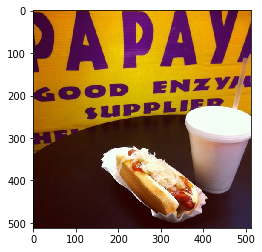

Augmented images:


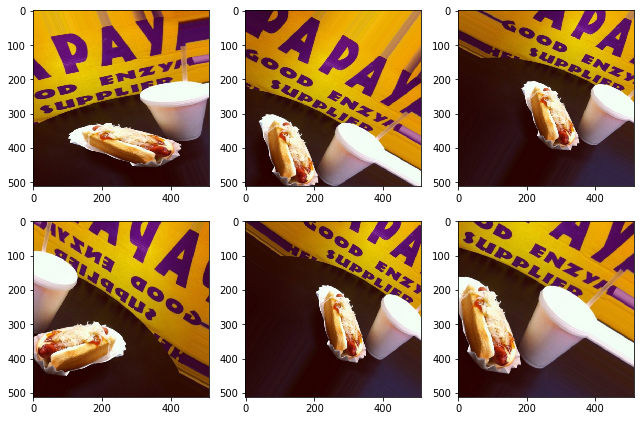

In [2]:
base_image = load_img("data/train/hot_dog/1000288.jpg")  # a PIL image
print("Base image:")
plt.imshow(base_image)
plt.show()

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)
x = img_to_array(base_image)  # a numpy array of shape (512, 512, 3)
x = x.reshape((1,) + x.shape)  # a numpy array of shape (1, 512, 512, 3)
image_gen = datagen.flow(x, batch_size=1)

fig = plt.figure(figsize=(9, 6))
gs = GridSpec(nrows=2, ncols=3)
print("Augmented images:")
for i in range(6):
    ax = fig.add_subplot(gs[i])
    aug_image = image_gen.next()[0]
    ax.imshow(array_to_img(aug_image))
fig.tight_layout()

## Training a small convnet from scratch

Our first model is a simple stack of 3 convolution layers with a ReLU activation followed by max-pooling layers. On top of it we add two fully-connected layers. We end the model with a single unit and a sigmoid activation for binary classification. To go with it we will also use the `binary_crossentropy` loss to train our model.

In [3]:
NB_TRAIN_SAMPLES = 498
NB_VALIDATION_SAMPLES = 500

IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 32

In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(
    loss="binary_crossentropy",
    optimizer=RMSprop(lr=1e-3),
    metrics=["accuracy"],
)

Let's prepare our data. We will use .flow_from_directory() to generate batches of image data and their labels directly from our jpgs in their respective folders.

As a part of image processing we will apply rescale transformation. Below ImageDataGenerator's `rescale` parameter is a value by which we will multiply the data before any other processing. Our original images consist of RGB coefficients in the 0-255, but such values would be too high for our models to process given a typical learning rate, so we target values between 0 and 1 instead by scaling with a 1/255 factor.

In [5]:
# augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, rotation_range=360, zoom_range=0.2, horizontal_flip=True
)

# augmentation configuration we will use for testing - only rescaling
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# a generator that will read pictures found in subfolers of 'data/train'
# and indefinitely generate batches of augmented image data.
train_generator = train_datagen.flow_from_directory(
    "data/train", target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE, class_mode="binary"
)

# a similar generator for validation data
validation_generator = test_datagen.flow_from_directory(
    "data/test", target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE, class_mode="binary"
)

Found 498 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


We can now use these generators to train our model. We will use a simple checkpointing strategy to save the best weights of our model. We will also use TensorBoard callback for visualization of training process.

In [6]:
# es = EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=1)

checkpoint_path = "auxiliary/custom_conv_model.h5"
checkpoint = ModelCheckpoint(
    checkpoint_path, monitor="val_acc", verbose=1, save_best_only=True, mode="max"
)

# tensorboard = TensorBoard(log_dir="auxiliary/logs", write_graph=True, write_images=True)

model.fit_generator(
    train_generator,
    steps_per_epoch=ceil(NB_TRAIN_SAMPLES / BATCH_SIZE),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=ceil(NB_VALIDATION_SAMPLES / BATCH_SIZE),
    callbacks=[checkpoint],
)

Epoch 1/100
16/16 [==============================] - 68s 4s/step - loss: 0.8549 - acc: 0.5781 - val_loss: 1.5143 - val_acc: 0.5580

Epoch 00001: val_acc improved from -inf to 0.55800, saving model to auxiliary/custom_conv_model.h5
Epoch 2/100
16/16 [==============================] - 56s 3s/step - loss: 0.8182 - acc: 0.5895 - val_loss: 1.0381 - val_acc: 0.5840

Epoch 00002: val_acc improved from 0.55800 to 0.58400, saving model to auxiliary/custom_conv_model.h5
Epoch 3/100
16/16 [==============================] - 56s 4s/step - loss: 0.7468 - acc: 0.6060 - val_loss: 0.8708 - val_acc: 0.6040

Epoch 00003: val_acc improved from 0.58400 to 0.60400, saving model to auxiliary/custom_conv_model.h5
Epoch 4/100
16/16 [==============================] - 56s 3s/step - loss: 0.7010 - acc: 0.6281 - val_loss: 0.9282 - val_acc: 0.5600

Epoch 00004: val_acc did not improve from 0.60400
Epoch 5/100
16/16 [==============================] - 68s 4s/step - loss: 0.6989 - acc: 0.6300 - val_loss: 0.8800 - val_

With a custom simple convnet model we were able to reach 69% accuracy on our validation set.